# A Hierarchical model for Rugby prediction

In [1]:
!date

import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
%matplotlib inline
import pymc3 as pm3, theano.tensor as tt

Wed 17 Jun 2015 22:06:33 CEST


:0: FutureWarning: IPython widgets are experimental and may change in the future.


This is a Rugby prediction exercise. So we'll input some data

In [3]:
data_csv = StringIO("""home_team,away_team,home_score,away_score
Wales,Italy,23,15
France,England,26,24
Ireland,Scotland,28,6
Ireland,Wales,26,3
Scotland,England,0,20
France,Italy,30,10
Wales,France,27,6
Italy,Scotland,20,21
England,Ireland,13,10
Ireland,Italy,46,7
Scotland,France,17,19
England,Wales,29,18
Italy,England,11,52
Wales,Scotland,51,3
France,Ireland,20,22""")

#The model.
<p>The league is made up by a total of T= 6 teams, playing each other once 
in a season. We indicate the number of points scored by the home and the away team in the g-th game of the season (15 games) as $y_{g1}$ and $y_{g2}$ respectively. </p>
<p>The vector of observed counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:
$y_{gi}| \theta_{gj} \tilde\;\;  Poisson(\theta_{gj})$
where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>

<p>We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
$$log \theta_{g1} = home + att_{h(g)} + def_{a(g)} $$
$$log \theta_{g2} = att_{a(g)} + def_{h(g)}$$
the parameter home represents the advantage for the team hosting the game
and we assume that this effect is constant for all the teams and
throughout the season. 




In [4]:
df = pd.read_csv(data_csv)

teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

In [5]:
model = pm3.Model()
with pm3.Model() as model:
    # global model parameters
    home        = pm3.Normal('home',      0, .0001)
    tau_att     = pm3.Gamma('tau_att',   .1, .1)
    tau_def     = pm3.Gamma('tau_def',   .1, .1)
    intercept   = pm3.Normal('intercept', 0, .0001)
    
    # team-specific model parameters
    atts_star   = pm3.Normal("atts_star", 
                           mu   =0,
                           tau  =tau_att, 
                           shape=num_teams)
    defs_star   = pm3.Normal("defs_star", 
                           mu   =0,
                           tau  =tau_def,  
                           shape=num_teams) 
 
    atts        = pm3.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs        = pm3.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta  = tt.exp(intercept + home + atts[away_team] + defs[home_team])
    away_theta  = tt.exp(intercept + atts[away_team] + defs[home_team])
    
    # likelihood of observed data
    home_points = pm3.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm3.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

* We specified the model and the likelihood function
* Now we need to fit our model using the Maximum A Posteriori algorithm to decide where to start out No U Turn Sampler

 [-----------------100%-----------------] 2000 of 2000 complete in 47.3 sec

/Users/peadarcoyle/anaconda/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  return f(*args, **kwds)


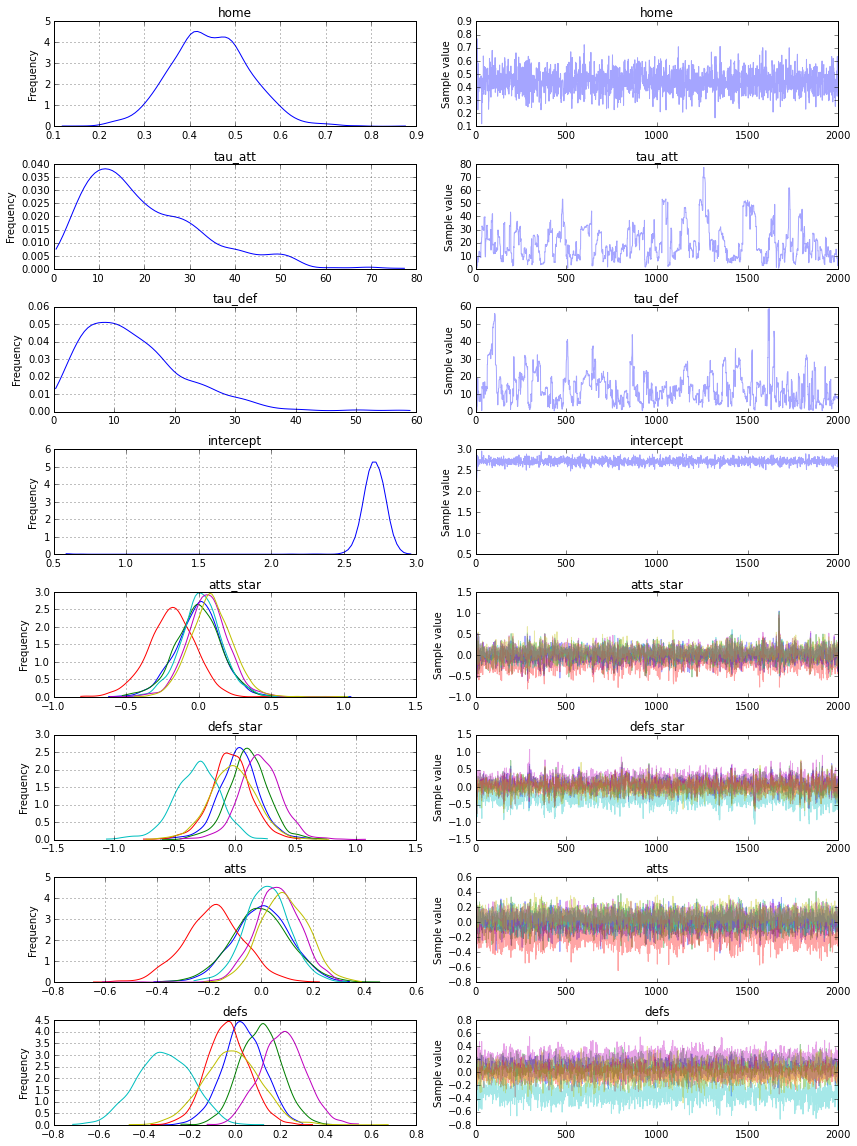

In [6]:
with model:

    start = pm3.find_MAP()
    step = pm3.NUTS(state=start)
    trace = pm3.sample(2000, step, start=start, progressbar=True)

    pm3.traceplot(trace)